##### DNN 기반 회귀 모델 구현
- 데이터셋   : iris.csv
- 피쳐/속성  : 4개 Sepal_Length, Sepal_width, Petal_Length, Petal_width
- 타겟/라벨  : 1개 Setosa와 나머지
- 학습/방법  : 지도학습 -> 회귀
- 알고리즘   : 인공신경망(ANN) -> MLP, DNN : 은닉층이 많은 구성
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# 모델 관련 모듈 로딩
import torch
import torch.nn as nn  
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# 데이터 관련 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

In [2]:
# 활용 패키지 버전 체크
print(f'torch V.:{torch.__version__}')
print(f'pandas V.:{pd.__version__}')

torch V.:2.4.1
pandas V.:2.0.3


In [3]:
## 데이터 로딩
DATA_FILE='../Data/iris.csv'

### CSV => DataFrame
irisDF = pd.read_csv(DATA_FILE)

### 확인
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [4]:
### 타겟 변경 => 정수화, 클래스 3개 => 2개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
irisDF['variety'] = (irisDF['variety'] == 'Setosa')
irisDF['variety']=irisDF['variety'].astype('int')

In [6]:
# labels=dict(zip(irisDF['variety'].unique().tolist(),range(3)))
# print(f'labels => {labels}')

[2] 모델 클래스 설계 및 정의 <hr>
- 클래스목적 : iris 데이터를 학습 및 추론
- 클래스이름 : irisBCFModel
- 부모클래스 : nn.Module
- 매개 변수 : 층별 입출력 개수 고정하기 때문에 필요 x!
- 속성 필드 : 
- 기능 역할 : __ init__() : 모델 구조 설정, forward() : 순방향 학습 <= 오버라이딩(overriding) - [상속 시 가능!]
- 클래스구조
    * 입력층 : 입력 4개(피쳐)  출력 10개 (퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개       출력 5개 (퍼셉트론/뉴런 30개 존재)
    * 출력층 : 입력 5개        출력 1개 (퍼셉트론/뉴런 1개 존재 : 2진분류)

- 활성화함수
    * 클래스 형태 ==> ex) nn.MESLoss, nn.ReLU ==> __ init__(self) 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward(self) 메서드

In [7]:
class irisBCFModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()
        
        self.in_layer=nn.Linear(4, 10)
        self.hidden_layer=nn.Linear(10, 5)
        self.out_layer=nn.Linear(5, 1)

    # 순방향 학습 진행 메서드
    def forward(self, x):
        # - 입력층
        y = self.in_layer(x)     # y = f1w1 + f2w2 + f3w3 + b ... -> 10개
        y = F.relu(y)            # relu -> y 값의 범위 0 <= y
        
        # - 은닉층 : 5개의 숫자 값(>=0)
        y = self.hidden_layer(y) # y = f21w21 + ... + f210w210 , ... -> 5개
        y = F.relu(y)            # relu -> y 값의 범위 0 <= y

        # - 출력층 : 1개의 숫자 값(>=0)
        return F.sigmoid(self.out_layer(y))        # f31w31 + ... f330w330 + b -> 1개

In [8]:
## 모델 인스턴스 생성
model = irisBCFModel()

print(model)

irisBCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [9]:
# 모델 사용 메모리 정보 확인
summary(model, input_size=(17,4)) # input_size = ,feature 개수)

Layer (type:depth-idx)                   Output Shape              Param #
irisBCFModel                             [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐_개수 : 3개
- 타겟_개수 : 1개
- 클래스이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성_필드 : featureDF, targetDF, n_rows, n_features
- 필수메서드 : 
    * __ init__(self): 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __ len__(self): 데이터의 개수 반환
    * __ getitem__(self, index): 특정 인덱스의 피쳐와 타겟 반환
    

In [10]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [11]:
## [테스트] 데이터셋 인스턴스 생성

# DataFrame에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]]     # 2D (150, 3)
targetDF = irisDF[irisDF.columns[-1:]]      # 2D (150, 1)

# - 커스텀데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF, targetDF)

# - 데이터로더 인스턴스 생성
irisDL=DataLoader(irisDS)

for feature, label in irisDL:
    print(feature.shape, label.shape)
    break

torch.Size([1, 4]) torch.Size([1, 1])


[4] 학습 준비 <hr>
- 학습 횟수 : EPOCH          <- 처음~ 끝까지 공부하는 단위
- 배치 크기 : BATCH_SIZE     <- 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE         <- 탠서 저장 및 실행 위치 (GPU/CPU)
- 학 습 률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001 ~ 0.1 (낮을수록 촘촘히)

In [12]:
### 학습 진행 관련 설정
EPOCHS = 1000
BATCH_SIZE = 10
BATCH_CNT = irisDF.shape[0]//BATCH_SIZE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

print(f'BATCH_CNT: {BATCH_CNT}')

BATCH_CNT: 15


- 인스턴스/객체 : 모델, 데이터셋, 최적화, (손실함수), (성능지표)

In [13]:
# 모델 인스턴스
model=irisBCFModel()

# 데이터셋 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)
print(f'[X_train(shape): {X_train.shape} (type): {type(X_train)}], X_test: {X_test.shape}, X_val: {X_val.shape}')
print(f'[y_train(shape): {y_train.shape} (type): {type(y_train)}], y_test: {y_test.shape}, y_val: {y_val.shape}')

trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# - 학습용 데이터로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

[X_train(shape): (84, 4) (type): <class 'pandas.core.frame.DataFrame'>], X_test: (38, 4), X_val: (28, 4)
[y_train(shape): (84, 1) (type): <class 'pandas.core.frame.DataFrame'>], y_test: (38, 1), y_val: (28, 1)


- 최적화, 손실함수 인스턴스 생성

In [14]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss => BCELoss
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리 후 전달
bce_loss = nn.BCELoss()

In [15]:
import math as m    
m.ceil

<function math.ceil(x, /)>

In [16]:
trainDS.n_rows, trainDS.featureDF.shape[0]

(84, 84)

[5] 학습 진행 <hr>

In [19]:
## 학습의 효과 확인 => 손실값과 성능평가값 저장 필요
loss_history, score_history=[[],[]], [[],[]] # train, val
CNT=len(trainDL)
print(f'new BATCH_CNT : {CNT}')
# 학습 모드로 모델 설정
model.train()

for epoch in range(1, EPOCHS):
    # 학습 모드로 모델 설정
    model.train()

    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0,0
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산
        loss=bce_loss(pre_y, targetTS)
        loss_total+=loss.item()
        
        # 성능평가 계산
        # score=F1Score(task='binary')(pre_y, targetTS)
        score=BinaryF1Score()(pre_y, targetTS)
        score_total+=score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 검증 모드로 모델 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)
        
        # 평가
        pre_val=model(val_featureTS)

        # 손실
        loss_val=bce_loss(pre_val, val_targetTS)

        # 성능평가
        # score_val=F1Score(task='binary')(pre_val, val_targetTS)
        score_val=BinaryF1Score()(pre_val, val_targetTS)

    # 에포크당 손실값과 성능평가값 저장
    loss_history[0].append(loss_total/epoch)
    score_history[0].append(score_total/epoch)

    loss_history[1].append(loss_val)
    score_history[1].append(score_val)

    print(f'{epoch}/{EPOCHS} => [TRAIN] LOSS: {loss_history[0][-1]} SCORE: {score_history[0][-1]}')
    print(f'[VAL] LOSS: {loss_history[1][-1]} SCORE: {score_history[1][-1]}')

new BATCH_CNT : 9
1/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
2/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
3/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
4/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
5/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
6/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
7/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
8/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
9/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
10/1000 => [TRAIN] LOSS: 0.005454874813556671 SCORE: 0.0
[VAL] LOSS: 0.7232764959335327 SCORE: 0.0
1

[테스트 & 검증 상태]
- 설정된 W,b 검증 및 테스트용 데이터셋 예측값 추출
- 사용되지 않는 기능들 OFF
- W, b 업데이트 X
    * -> 기능 OFF Auto_grade 엔진 ---> model.eval()
    * -> W, b 텐서 required_grade=True ---> no.grad()

[6] 학습결과 시각화
- 학습과 검증의 Loss 변화, 성능 변화 체크

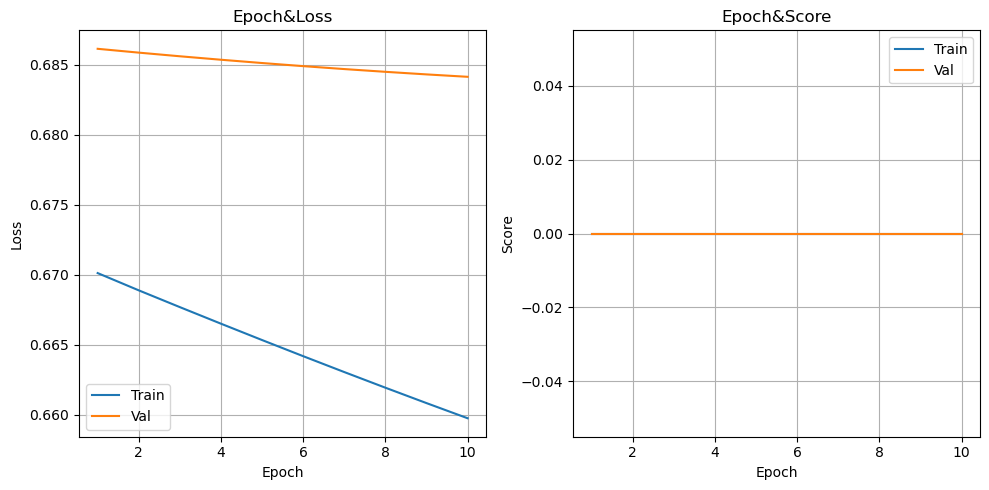

In [18]:
# 학습 후 loss 시각화

THRESHOLD=10
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss_history[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss_history[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), score_history[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), score_history[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Epoch&Score')
plt.tight_layout()
plt.show()